In [118]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN, MeanShift, estimate_bandwidth, KMeans, OPTICS, cluster_optics_dbscan, AffinityPropagation
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [119]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.drop(['id'], axis=1,inplace=True)
df.info()
# df['stroke']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [120]:
df['gender']=df['gender'].apply(lambda x : 1 if x=='Male' else 0) 
df["ever_married"] = df["ever_married"].apply(lambda x: 1 if x=="Yes" else 0)
df["Residence_type"] = df["Residence_type"].apply(lambda x: 1 if x=="Urban" else 0)

df = pd.get_dummies(data=df, columns=['smoking_status'])
df = pd.get_dummies(data=df, columns=['work_type'])

X = df.drop(['stroke'], axis=1).values
imputer = SimpleImputer()
X = imputer.fit_transform(X)

y = df['stroke'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

df

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,1,67.0,0,1,1,1,228.69,36.6,1,0,1,0,0,0,0,1,0,0
1,0,61.0,0,0,1,0,202.21,NaN,1,0,0,1,0,0,0,0,1,0
2,1,80.0,0,1,1,0,105.92,32.5,1,0,0,1,0,0,0,1,0,0
3,0,49.0,0,0,1,1,171.23,34.4,1,0,0,0,1,0,0,1,0,0
4,0,79.0,1,0,1,0,174.12,24.0,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,1,83.75,NaN,0,0,0,1,0,0,0,1,0,0
5106,0,81.0,0,0,1,1,125.20,40.0,0,0,0,1,0,0,0,0,1,0
5107,0,35.0,0,0,1,0,82.99,30.6,0,0,0,1,0,0,0,0,1,0
5108,1,51.0,0,0,1,0,166.29,25.6,0,0,1,0,0,0,0,1,0,0


In [148]:
df1 = pd.DataFrame(X)
# statistical analysis of bmi
df1.iloc[:,7].describe()

count    5110.000000
mean       28.893237
std         7.698018
min        10.300000
25%        23.800000
50%        28.400000
75%        32.800000
max        97.600000
Name: 7, dtype: float64

In [122]:
# imputer = SimpleImputer()
x = df.iloc[:,[1,7,8]]
x = imputer.fit_transform(x)
x = np.array(x)
x

array([[67.        , 36.6       ,  1.        ],
       [61.        , 28.89323691,  1.        ],
       [80.        , 32.5       ,  1.        ],
       ...,
       [35.        , 30.6       ,  0.        ],
       [51.        , 25.6       ,  0.        ],
       [44.        , 26.2       ,  0.        ]])

In [123]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

x1 = x[:,1]
y = x[:,2]

x1 = x1[:,np.newaxis]

# x_train, x_test, y_train, y_test = train_test_split(x1, x2, random_state=0)

# y_train_binned = np.digitize(y_train,bins=[i])


svm = SVC(kernel='rbf', random_state=0, gamma=0.5, C=1)

svm.fit(x1,y)

y_pred = svm.predict(x1)

accuracy = metrics.accuracy_score(y,y_pred)
precision = metrics.precision_score(y,y_pred)
class_report = metrics.classification_report(y,y_pred)

print(accuracy)
print(precision)
print(class_report)


0.9512720156555773
0.0
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98      4861
         1.0       0.00      0.00      0.00       249

    accuracy                           0.95      5110
   macro avg       0.48      0.50      0.49      5110
weighted avg       0.90      0.95      0.93      5110



C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to

C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to

0.9512720156555773
0.0
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98      4861
         1.0       0.00      0.00      0.00       249

    accuracy                           0.95      5110
   macro avg       0.48      0.50      0.49      5110
weighted avg       0.90      0.95      0.93      5110



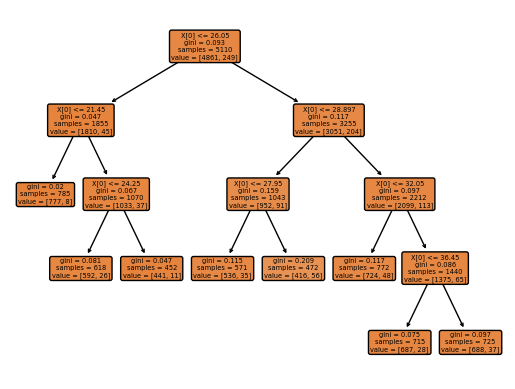

In [124]:
from sklearn import tree

dt = tree.DecisionTreeClassifier(min_samples_leaf=450)
dt = dt.fit(x1,y)

# tree.plot_tree(dt)

dot_data = tree.export_graphviz(dt, out_file=None)
tree.plot_tree(dt, filled=True, rounded=True)

accuracy = metrics.accuracy_score(y,y_pred)
precision = metrics.precision_score(y,y_pred)
class_report = metrics.classification_report(y,y_pred)

print(accuracy)
print(precision)
print(class_report)

In [125]:
db = DBSCAN(eps=0.3, min_samples=10).fit(x)
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

class_report = metrics.classification_report(y, labels)

print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")
print(class_report)

Estimated number of clusters: 5
Estimated number of noise points: 5058
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       1.00      0.00      0.00      4861
         1.0       0.00      0.00      0.00       249
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0

    accuracy                           0.00      5110
   macro avg       0.17      0.00      0.00      5110
weighted avg       0.95      0.00      0.00      5110



C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



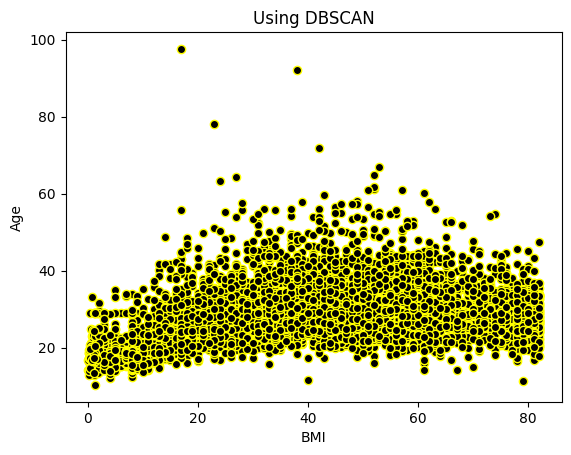

In [126]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

x1 = x[:,[0,1]]

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = x1[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="green",
        markersize=14,
    )

    xy = x1[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="yellow",
        markersize=6,
    )

plt.title("Using DBSCAN")
plt.xlabel("BMI")
plt.ylabel("Age")
plt.show()

In [127]:
bandwidth = estimate_bandwidth(x, quantile=0.2,n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(x)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

class_report = metrics.classification_report(y,labels)
silhoutte = metrics.silhouette_score(x,labels)
print(f"Number of estimated clusters: {n_clusters_}")
print(class_report)
print(silhoutte)

C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



Number of estimated clusters: 5
              precision    recall  f1-score   support

         0.0       0.93      0.66      0.77      4861
         1.0       0.00      0.01      0.00       249
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0

    accuracy                           0.63      5110
   macro avg       0.19      0.13      0.15      5110
weighted avg       0.88      0.63      0.73      5110

0.4601834589947661


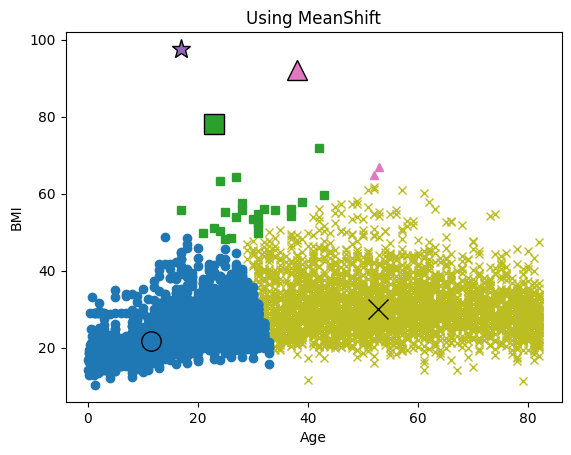

In [128]:
plt.figure(1)
plt.clf()

x1 = x[0,1]

colors = ["tab:olive", "tab:blue", "tab:pink","tab:green", "tab:purple", "tab:cyan"]

markers = ["x", "o", "^", "s", "*", "+"]

for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(x[my_members, 0], x[my_members, 1], markers[k], color=col)
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        markers[k],
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
plt.title("Using MeanShift")

plt.xlabel("Age")
plt.ylabel('BMI')
plt.show()

In [129]:
km = KMeans(n_clusters=2,
init = 'random', n_init = 5,
max_iter = 100, tol = 0.01)

y_km = km.fit_predict(x)

labels = km.labels_

print(x[y_km == 0,0])

silhoutte = metrics.silhouette_score(x,labels)
class_report = metrics.classification_report(y, labels)

print(silhoutte)
print(class_report)

[67. 61. 80. ... 81. 51. 44.]
0.5331201648835416
              precision    recall  f1-score   support

         0.0       0.91      0.53      0.67      4861
         1.0       0.00      0.04      0.01       249

    accuracy                           0.50      5110
   macro avg       0.46      0.28      0.34      5110
weighted avg       0.87      0.50      0.64      5110



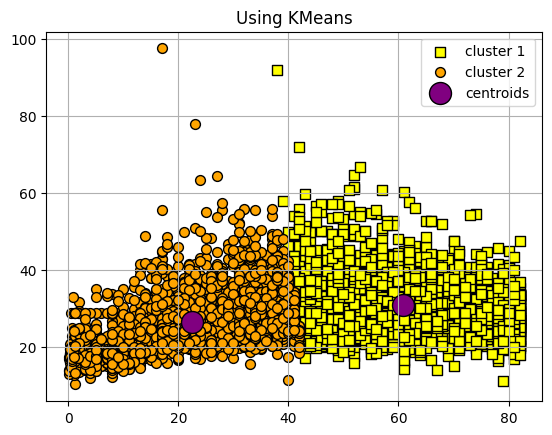

In [130]:
plt.scatter(
    x[y_km == 0,0], x[y_km == 0,1], s=50, c='yellow', marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    x[y_km == 1, 0], x[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    km.cluster_centers_[:,0], km.cluster_centers_[:,1],
    s=250,edgecolors="black", c='purple',
    label='centroids'
)

plt.legend(scatterpoints=1)
plt.title("Using KMeans")
plt.grid()
plt.show()

C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98      4861
         1.0       0.00      0.00      0.00       249

    accuracy                           0.95      5110
   macro avg       0.48      0.50      0.49      5110
weighted avg       0.90      0.95      0.93      5110



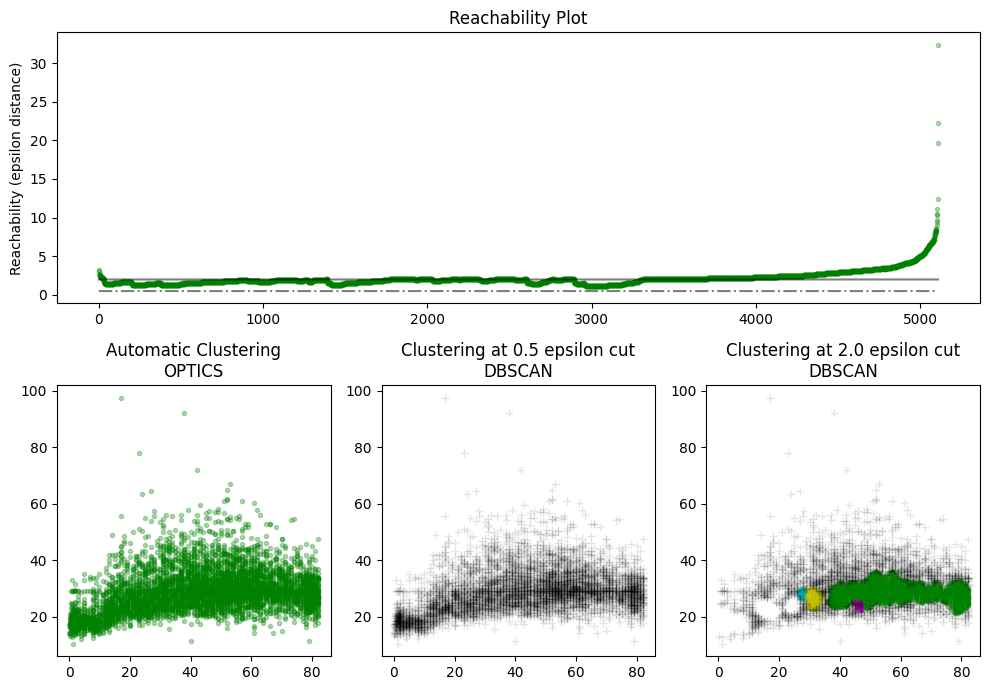

In [131]:
clust = OPTICS(min_samples=50,xi=0.05,min_cluster_size=0.05)

clust.fit(x)

labels = clust.labels_

class_report = metrics.classification_report(y, labels)

print(class_report)

labels_050 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=0.5,
)
labels_200 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=2,
)

space = np.arange(len(x))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gs.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# OPTICS
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = x[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(x[clust.labels_ == -1, 0], x[clust.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at 0.5
colors = ["g.", "r.", "b.", "c."]
for klass, color in zip(range(0, 4), colors):
    Xk = x[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax3.plot(x[labels_050 == -1, 0], x[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at 2.
colors = ["g.", "m.", "y.", "c."]
for klass, color in zip(range(0, 4), colors):
    Xk = x[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(x[labels_200 == -1, 0], x[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning:

Clustering metrics expects discrete values but received continuous

              precision    recall  f1-score   support

         0.0       0.60      0.00      0.00      4861
         1.0       0.25      0.01      0.02       249
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0
         5.0       0.00      0.00      0.00         0
         6.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00         0
         8.0       0.00      0.00      0.00         0
         9.0       0.00      0.00      0.00         0
        10.0       0.00      0.00      0.00         0
        11.0       0.00      0.00      0.00         0
        12.0       0.00      0.00      0.00         0
        13.0       0.00      0.00      0.00         0
        14.0       0.00      0.00      0.00         0
        15.0       0.00      0.00      0.00         0
        16.0       0.00      0.00      0.00         0
        17.0       0.00    

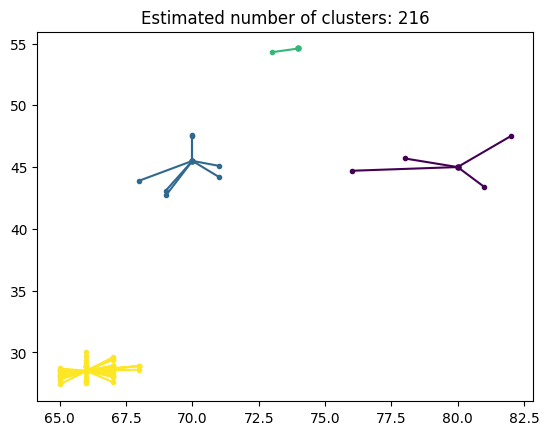

In [132]:
af = AffinityPropagation(preference=-50, random_state=0).fit(x)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

# silhoutte = metrics.silhouette_score(x,labels)
class_report = metrics.classification_report(y, labels)

# print(silhoutte)
print(class_report)

n_clusters_ = len(cluster_centers_indices)

x1 = x[:, 1]

print("Estimated number of clusters: %d" % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(x1, labels))
print("Completeness: %0.3f" % metrics.completeness_score(x1, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(x1, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(x1, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(x1, labels)
)
print(
    "Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(x, labels, metric="sqeuclidean")
)

plt.close("all")
plt.figure(1)
plt.clf()

colors = plt.cycler("color", plt.cm.viridis(np.linspace(0, 1, 4)))

for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = x[cluster_centers_indices[k]]
    plt.scatter(
        x[class_members, 0], x[class_members, 1], color=col["color"], marker="."
    )
    plt.scatter(
        cluster_center[0], cluster_center[1], s=14, color=col["color"], marker="o"
    )
    for i in x[class_members]:
        plt.plot(
            [cluster_center[0], i[0]], [cluster_center[1], i[1]], color=col["color"]
        )
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

[0.11106353]
mean absolute error: 5.2
mean squared error: 45.27
root mean squared error: 6.73


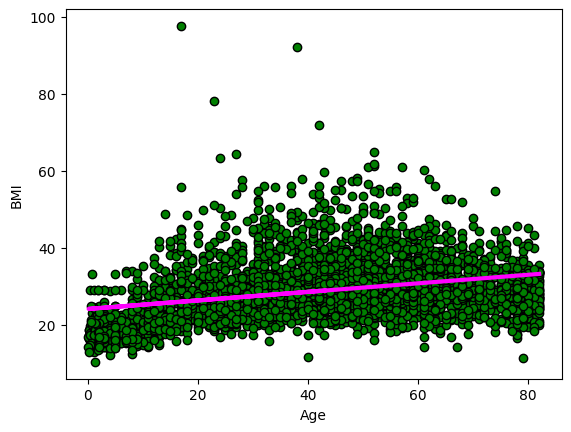

In [133]:
from sklearn.linear_model import LinearRegression

def root_mean_squared_error(actual,prediction):
    return np.sqrt(metrics.mean_squared_error(actual,prediction))

x1 = x[:,0]
x2 = x[:,1]


x1 = x1[:,np.newaxis]

x_train, x_test, y_train, y_test = train_test_split(x1, x2, random_state=0)

lr = LinearRegression()
lr.fit(x_train, y_train)
print(lr.coef_)

y_pred = lr.predict(x_test)

mar = metrics.mean_absolute_error(y_test,y_pred)
mse = metrics.mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"mean absolute error: {round(mar,2)}")
print(f"mean squared error: {round(mse,2)}")
print(f"root mean squared error: {round(rmse,2)}")

plt.scatter(x_train, y_train, color='green', edgecolors='black')
plt.plot(x_test, y_pred, color="magenta", linewidth=3)

plt.xticks()
plt.yticks()

plt.xlabel("Age")
plt.ylabel("BMI")

plt.show()


[ 0.          0.57250523 -0.00554262]
mean absolute error: 4.79
mean squared error: 39.19
root mean squared error: 6.26


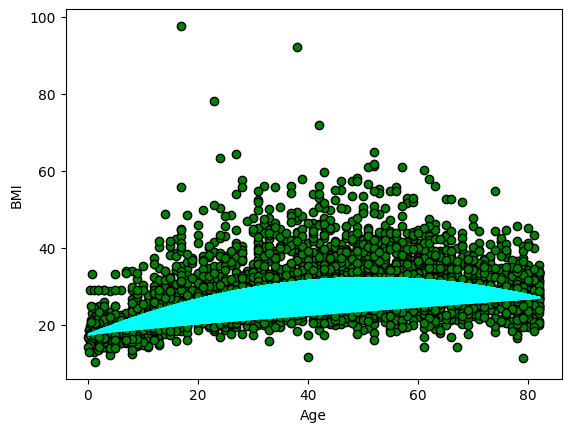

In [134]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(x_train)

poly_reg_model = LinearRegression()
poly_reg_model.fit(X_poly,y_train)
print(poly_reg_model.coef_)

y_pred = poly_reg_model.predict(poly_reg.fit_transform(x_test))

mar = metrics.mean_absolute_error(y_test,y_pred)
mse = metrics.mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"mean absolute error: {round(mar,2)}")
print(f"mean squared error: {round(mse,2)}")
print(f"root mean squared error: {round(rmse,2)}")

plt.scatter(x_train, y_train,color='green',edgecolors='black')
plt.plot(x_test,y_pred, color='cyan')

plt.xlabel("Age")
plt.ylabel("BMI")

plt.show()

In [143]:
import plotly.graph_objects as go

color_palette = ['#1CC7F9', '#2DE31E', '#F98A1C']

# df.drop(['gender','ever_married','Residence_type','smoking_status_Unknown','smoking_status_formerly smoked','smoking_status_never smoked',
#         'smoking_status_smokes','work_type_Govt_job','work_type_Never_worked','work_type_Private','work_type_Self-employed','work_type_children'], axis=1, inplace=True)

corr = df.corr()

fig = go.Figure(data= go.Heatmap(z=corr,
                                 x=corr.index.values,
                                 y=corr.columns.values,
                                 colorscale=color_palette,
                                 text = corr.round(2), texttemplate="%{text}", xgap=3, ygap=3
                                 )
                )

fig.update_layout(title_text='<b>Correlation Matrix<b>',
                  title_x=0.5,
                  titlefont={'size': 24, 'family': 'Courier New'},
                  width=900, height=600,
                  xaxis_showgrid=False,
                  yaxis_showgrid=False,
                  yaxis_autorange='reversed', 
                  paper_bgcolor=None,
                  template='seaborn'
                  )

In [149]:
from sklearn.ensemble import RandomForestClassifier
import plotly.figure_factory as ff

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

#Score 
rfc_score = rfc.score(X_train, y_train)
rfc_test = rfc.score(X_test, y_test)

# Model Testing
y_pred = rfc.predict(X_test)

# Evaluation
rfc_cm = metrics.confusion_matrix(y_test,y_pred)
class_report = metrics.classification_report(y_test,y_pred)
print(f'Training Score: {rfc_score.round(3)}')
print(f'Testing Score: {rfc_test.round(3)}')
print(f'Classification report: {class_report}')

conf_matrix = pd.DataFrame(data=rfc_cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
print(f'Accuracy Score: {metrics.accuracy_score(y_test,y_pred).round(3)}')

z=rfc_cm
fig = ff.create_annotated_heatmap(z, x=['Not Stroke','Stroke'], y=['Predicted Not Stroke','Predicted Stroke'], colorscale='Fall',xgap=3,ygap=3)
fig['data'][0]['showscale'] = True

fig.update_layout(title_text='<b>Confusion Matrix for Random Forest Classifier<b>',
                  title_x=0.5,
                  titlefont={'size': 24, 'family': 'Courier New'},
                  width=900, height=400,
                  xaxis_showgrid=False,
                  yaxis_showgrid=False,
                  yaxis_autorange='reversed', 
                  paper_bgcolor=None,
                  template='seaborn'
                  )

fig.show()

Training Score: 1.0
Testing Score: 0.948
Classification report:               precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       968
         1.0       1.00      0.02      0.04        54

    accuracy                           0.95      1022
   macro avg       0.97      0.51      0.50      1022
weighted avg       0.95      0.95      0.92      1022

Accuracy Score: 0.948
